<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/spcay_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [3]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [4]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [5]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [6]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [7]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [8]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product'],
      dtype=object)

In [9]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product'}

In [10]:
df['topic'] = df['topic'].map(topic_dic)

<Axes: xlabel='count', ylabel='topic'>

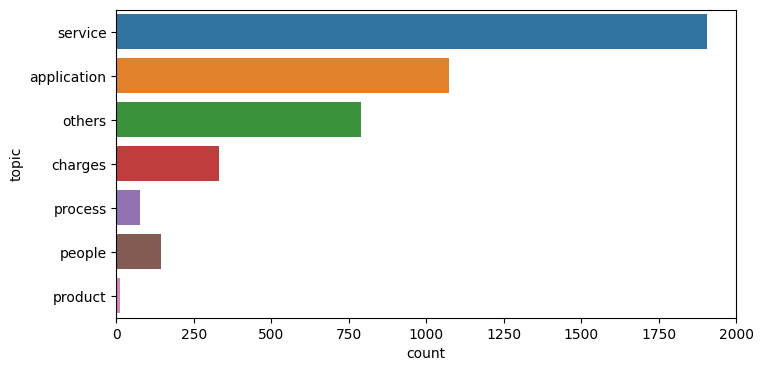

In [11]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [12]:
# Preprocessing

In [13]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [14]:
import re

In [15]:
def preprocess_text(text):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())
    return text

In [16]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x))
# df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,same day money deduction even if we have marg...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,no technical support at real time application ...,service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charges...,charges
7,iâm waiting for resolution or a meeting with...,service,i m waiting for resolution or a meeting with m...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issues with the rm,service


In [17]:
df = df[['x', 'y']]

In [55]:
text = ". ".join(df[df['y']=='people']['x'])

In [19]:
# SpaCy for text summarization

In [20]:
import spacy

# Load the small English model
nlp = spacy.load("en_core_web_sm")

def summarize_text(input_text, num_sentences=3):
    # Parse the input text with Spacy
    doc = nlp(input_text)

    # Extract the sentences as a list of strings
    sentences = [sent.text.strip() for sent in doc.sents]

    # Calculate the total number of sentences and the number to keep for the summary
    num_total_sentences = len(sentences)
    num_summary_sentences = min(num_sentences, num_total_sentences)

    # Calculate the "importance score" for each sentence
    scores = {}
    for i, sent in enumerate(sentences):
        # Split the sentence into individual words
        words = sent.split()

        # Calculate the average word vector for the sentence
        word_vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
        if len(word_vectors) > 0:
            sent_vector = sum(word_vectors) / len(word_vectors)
        else:
            sent_vector = nlp("")[0].vector

        # Calculate the cosine similarity between the sentence vector and the document vector
        doc_vector = doc.vector
        sim = sent_vector.dot(doc_vector) / (np.linalg.norm(sent_vector) * np.linalg.norm(doc_vector))
        scores[i] = sim

    # Sort the sentences by score and keep the top N
    top_sentences = sorted(scores, key=scores.get, reverse=True)[:num_summary_sentences]

    # Sort the top sentences back into their original order
    summary = [sentences[i] for i in sorted(top_sentences)]

    # Join the summary sentences into a single string
    return " ".join(summary)


In [21]:
input_text = text
summary = summarize_text(input_text, num_sentences=5)
print(summary)


its very unfair to point out only dealer problem kotak securities is very back dated not client friendly please try to value add in various aspect knowledge technical try to reduce brokerage burden dont change dealer frequently bcoz clint dealer relationship make more confidence must improve technology part of your platform technology glitches make us most irritation . its very unfair to point out only dealer problem kotak securities is very back dated not client friendly please try to value add in various aspect knowledge technical try to reduce brokerage burden dont change dealer frequently bcoz clint dealer relationship make more confidence must improve technology part of your platform technology glitches make us most irritation . there should be dedicated person at branch level to advise on the software plat form operation generalists person with no knowledge about the operation of trading platform software from customer s point of view is totally lacking. all kotak securities team

In [22]:
# Transformers 

In [23]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [24]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00


In [25]:
from transformers import pipeline

# Load the pre-trained summarization model
summarizer = pipeline("summarization")



No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [26]:
def generate_summary(text):
    preprocessed_text = text
    
    # Generate the summary using the abstractive summarization model
    summary = summarizer(preprocessed_text, max_length=100, min_length=30, do_sample=False)
    
    # Return the generated summary
    return summary[0]['summary_text']
generate_summary(text)

Token indices sequence length is longer than the specified maximum sequence length for this model (4630 > 1024). Running this sequence through the model will result in indexing errors


IndexError: ignored

In [27]:
# Gensim

In [37]:
pip install gensim==3.8.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.0-cp310-cp310-linux_x86_64.whl size=24954760 sha256=047b0d3dfc295af4f6878fb2985b39e46a73f4957ff1134b70dab0bb4f92e947
  Stored in directory: /root/.cache/pip/wheels/01/ab/bf/07d4e3462e9f8d17d98c2fb5e870d7e9934c8482a32fc3ef41
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [32]:
import gensim
from gensim.summarization import summarize

def generate_summary(text):
    # Preprocess the text if needed
    # ...

    # Generate the summary using Gensim's summarize function
    summary = summarize(text)

    return summary

# Example usage
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed luctus ligula et augue varius, " \
       "at tincidunt leo tincidunt. In ut sem tristique, luctus nunc sit amet, euismod sem. Nullam " \
       "aliquet lacus non arcu luctus placerat. Sed pharetra justo et bibendum malesuada. Vestibulum " \
       "lobortis ante vitae nibh malesuada semper. Quisque nec risus ac nisi dignissim gravida. " \
       "Donec iaculis justo non varius congue. Cras nec risus velit. Nullam et ipsum eu arcu interdum " \
       "venenatis sed sed leo."

summary = generate_summary(text)
print(summary)


ModuleNotFoundError: ignored

In [35]:
print(gensim.__version__)

4.3.1


In [39]:
pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 35.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21696 sha256=67a5a91f8a811c25f119761d17f2dc1a4f4f3a95ce4a9b0846e6bfc2216bb73e
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=3aef6dc9c3adda4a7bdb7ce2b9fec3ed6a325ccc5d1d9f8307c1cce4cf17a9a3
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506

In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [56]:
import tensorflow as tf
import tensorflow_hub as hub
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# Load the ELMo module
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def generate_summary(text, num_sentences=3):
    # Preprocess the text if needed
    # ...

    # Generate ELMo embeddings for the input text
    embeddings = elmo.signatures["default"](tf.constant([text]))["elmo"]

    # Convert embeddings to numpy array
    embeddings = embeddings.numpy()

    # Reshape the embeddings
    embeddings = embeddings.reshape(-1, embeddings.shape[-1])

    # Initialize the parser and tokenizer
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # Initialize the LexRank summarizer
    summarizer = LexRankSummarizer()

    # Generate the summary
    summary = summarizer(parser.document, num_sentences)

    # Combine the sentences into a single summary string
    summary_text = " ".join(str(sentence) for sentence in summary)

    return summary_text

you need to improve your system and your portal as well i have been stugling to find answers to my questions no reply since morning i have sent a mail once asked by your employee i e your dedicated person but no reply no knowledge they have no queries they are able to resolve they only say will get back once boss approve based in my request from boss very unprofessional does match up with kotak standards not a single question they answered no clarity your team has take for example todays maul of mine so far no reply to simple question leave aside what we speak on phone soon i shall shift my account useless service your helpline mos they dont have any answer and when they are uncomfortable with questions they disconnect the phone u have been struggling for answere for last days since you monitor the call for quality purspoes you can listen to my conversations very bad experience with dmat acoount. all kotak securities team is frod they dont have knowledge off there apps customer care al

In [ ]:
# Example usage

summary = generate_summary(text)
print(summary)